In [2]:
!pip install datasets torchtext tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━

In [3]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [4]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

I leverage the Hugging Face datasets library to effortlessly load the IMDB movie review dataset, which is a benchmark dataset for sentiment analysis tasks. I split the data into training and testing sets to properly evaluate the model's performance. Then, to get a sense of the data I'll be working with, I print the text of the first review and its associated label from the training set. This initial exploration is critical for understanding the data's format and for making informed decisions on preprocessing steps. The label 0 indicates a negative review, while 1 signifies a positive review, setting the stage for a binary classification problem.

In [5]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])
print(train_data['text'][0])
print(train_data['label'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

Here, I'm setting up the tokenization process for the IMDB dataset to prepare it for model training. I start by selecting a basic English tokenizer from torchtext.data.utils, which breaks down the text into individual words or tokens. I then define a function, tokenize_example, that applies this tokenizer to each movie review. To ensure uniformity and manage computational resources efficiently, I truncate or pad the sequences to a maximum length of 512 tokens. This function not only tokenizes the text but also records the length of the tokenized sequence, which can be useful for batching and padding later on. Lastly, I apply this tokenization function to both the training and testing datasets using the .map method, which efficiently processes each example in the dataset. This step is crucial for converting raw text into a format that's more suitable for the neural network models to process.

In [6]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

max_length = 512

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
print(train_data['text'][0])
print(train_data['label'][0])
print(train_data['tokens'][0])
print(train_data['length'][0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [8]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

print(train_data)
print(valid_data)

Dataset({
    features: ['text', 'label', 'tokens', 'length'],
    num_rows: 18750
})
Dataset({
    features: ['text', 'label', 'tokens', 'length'],
    num_rows: 6250
})


I'm constructing the vocabulary for our dataset, which is a crucial step for text representation in machine learning models. By leveraging torchtext.vocab.build_vocab_from_iterator, I iterate over the tokenized text from the training dataset to create the vocabulary, only including tokens that appear at least 3 times (min_freq=3). This approach helps reduce the size of the vocabulary, focusing on more frequent words to minimize the impact of rare words on the model's performance.

I also specify special tokens, <unk> and <pad>, to handle unknown words and padding, respectively. These tokens are essential for dealing with words not found in the vocabulary during the training or prediction phase and for ensuring consistent sequence lengths across the dataset.

After constructing the vocabulary, I retrieve and store the indices for these special tokens, setting <unk> as the default index. This means any word not found in the vocabulary will be represented by the <unk> token during the tokenization process, maintaining a manageable and effective vocabulary size for model training.

In [9]:
min_freq = 3
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

vocab.set_default_index(unk_index)

In this step, I've created a function called numericalize_example that converts the tokenized text into numerical IDs using the vocabulary we previously built. This numerical representation is essential for training machine learning models as it converts text into a format that the models can understand and process. By calling vocab.lookup_indices, I transform each token into its corresponding index in the vocabulary. This process is applied to the training, validation, and testing datasets to ensure consistency across the data used for model training and evaluation.

After numericalizing the tokens, I set the datasets' format to PyTorch tensors (type="torch"), selecting only the relevant columns: the token IDs (ids), labels (label), and sequence lengths (length). This transformation is critical for seamless integration with PyTorch's data loading and training mechanisms, facilitating efficient batching and data manipulation during model training.

Lastly, I access the first element of the transformed training data to inspect the structure and verify the successful application of the processing steps. This check ensures that the data is correctly prepared and ready for the next stages of the machine learning pipeline.

In [10]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

train_data[0]

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

{'label': tensor(1),
 'length': tensor(135),
 'ids': tensor([  177,     4,    14,    10,   187,   821,    35,     7,     2,   125,
           104,   818,    51,     8,  1492,     2,   362,     7,     2,   184,
             3,     8,   805,    14,    19,    10,     8,   805,  2168,   414,
             3,    13,   379,    15,     2,   386,  1098,     9,    16,    77,
             6,    67,     7, 12072,     3,     2,  8824,    17,   787,     4,
          8355,  5637,   190,    37,     4,     5,  3569,  3461,    17,   224,
             6, 10177,     3,    53,     7,    15,  3051,   370,     6,   652,
             4, 20199,  5815,     3,  2581,  3876,     9,    16,   241,    12,
            14,    19,  1152,    31,    17,   123,   182,     8,    34,   584,
           183,    18,     6,    35,  4221,  1295,    12,     2,  5004,     3,
            32,  4201,    10,    41,  2831,     8,    37,     3,     2,  4294,
          1095,   205,  2843,     5, 19705,  3637,   562,  5269,     8,  2528,


Here, I design a custom collate function to handle the batching of our text data efficiently, crucial for training deep learning models with variable-length inputs. The get_collate_fn function generates a collate_fn that takes a batch of preprocessed data samples and performs two main operations: padding and batching.

Padding: Since each text sequence can have a different length, I use nn.utils.rnn.pad_sequence to pad the sequences in the batch to the longest sequence's length, ensuring uniformity. The padding_value is set to the index of the <pad> token in our vocabulary, allowing the model to easily distinguish padded elements from actual data.

Batching: I then aggregate the padded token IDs, sequence lengths, and labels from the batch into tensors. This aggregation step converts the variable-length sequences and their labels into PyTorch tensors that can be processed by the model in batches, significantly improving training efficiency.

The get_data_loader function utilizes this collate_fn to create a DataLoader for our dataset. The DataLoader handles the iteration over batches of data, applying our custom collate_fn to each batch. It supports both shuffling (useful during training to prevent the model from learning the order of the data) and static ordering (useful during evaluation for consistency).

By integrating these custom functions into our data processing pipeline, I ensure that our model receives well-structured and appropriately padded batches of data, enabling effective and efficient training on text data of varying lengths.

In [11]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}

        return batch

    return collate_fn


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

    return data_loader

In [12]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

Below code defines a class for a custom LSTM model, tailored for sentiment analysis or similar sequence-based tasks. I initialize the model with several configurable parameters like vocabulary size, embedding dimension, hidden dimension, output dimension, number of LSTM layers, bidirectional flag, dropout rate, and the padding index. The core components include an embedding layer for word representations, an LSTM layer for sequence processing, a fully connected layer for output generation, dropout for regularization, and batch normalization to stabilize and speed up training.

In the forward method, I process input sequences through the embedding layer, apply dropout, and then pack the sequences to efficiently handle varying lengths. The LSTM processes these packed sequences, and I apply dropout and batch normalization to the outputs. For bidirectional LSTMs, I concatenate the final forward and backward hidden states to form a unified feature vector for each sequence. This vector is then passed through the fully connected layer to produce the final output.

Additionally, I implement a summary method using the PrettyTable library to print a detailed summary of the model, including configurations and a breakdown of parameters by layer. This method is incredibly useful for debugging, understanding the model's architecture, and ensuring that the parameter count aligns with expectations, thus providing insights into the model's complexity and potential computational demands.

In [13]:
from prettytable import PrettyTable

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, pad_index):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout_rate = dropout_rate
        self.pad_index = pad_index

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2 if bidirectional else hidden_dim)

    def forward(self, ids, length):
        embedded = self.dropout(self.embedding(ids))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        output = self.dropout(output)
        output = self.batch_norm(output.view(-1, output.shape[2])).view(ids.size(0), -1, output.shape[2])

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        else:
            hidden = self.dropout(hidden[-1])

        prediction = self.fc(hidden)
        return prediction

    def summary(self):
        summary_table = PrettyTable()
        summary_table.field_names = ["Parameter", "Value"]

        summary_table.add_row(["Vocab Size", self.vocab_size])
        summary_table.add_row(["Embedding Dimension", self.embedding_dim])
        summary_table.add_row(["Hidden Dimension", self.hidden_dim])
        summary_table.add_row(["Output Dimension", self.output_dim])
        summary_table.add_row(["Number of Layers", self.n_layers])
        summary_table.add_row(["Bidirectional", "Yes" if self.bidirectional else "No"])
        summary_table.add_row(["Dropout Rate", self.dropout_rate])
        summary_table.add_row(["Padding Index", self.pad_index])

        layer_table = PrettyTable()
        layer_table.field_names = ["Layer", "Parameters", "Trainable"]

        total_params = 0
        total_trainable_params = 0

        for name, parameter in self.named_parameters():
            param = parameter.numel()
            trainable = parameter.requires_grad
            layer_table.add_row([name, param, "Yes" if trainable else "No"])
            total_params += param
            if trainable:
                total_trainable_params += param

        model_size = total_params * torch.tensor(0).element_size() / (1024 ** 2)

        summary_table.add_row(["Total Parameters", total_params])
        summary_table.add_row(["Trainable Parameters", total_trainable_params])
        summary_table.add_row(["Model Size (MB)", f"{model_size:.2f}"])

        print("LSTM Model Summary:")
        print(summary_table)
        print("\nDetailed Parameters by Layer:")
        print(layer_table)

In [14]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, pad_index)
model.summary()

LSTM Model Summary:
+----------------------+----------+
|      Parameter       |  Value   |
+----------------------+----------+
|      Vocab Size      |  33522   |
| Embedding Dimension  |   300    |
|   Hidden Dimension   |   300    |
|   Output Dimension   |    2     |
|   Number of Layers   |    2     |
|    Bidirectional     |   Yes    |
|     Dropout Rate     |   0.5    |
|    Padding Index     |    1     |
|   Total Parameters   | 13668602 |
| Trainable Parameters | 13668602 |
|   Model Size (MB)    |  104.28  |
+----------------------+----------+

Detailed Parameters by Layer:
+---------------------------+------------+-----------+
|           Layer           | Parameters | Trainable |
+---------------------------+------------+-----------+
|      embedding.weight     |  10056600  |    Yes    |
|     lstm.weight_ih_l0     |   360000   |    Yes    |
|     lstm.weight_hh_l0     |   360000   |    Yes    |
|      lstm.bias_ih_l0      |    1200    |    Yes    |
|      lstm.bias_hh_l0  

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 13,668,602 trainable parameters


I define a function initialize_weights to initialize the weights of my LSTM model systematically, ensuring that the model starts training from a stable and optimized point. This approach is crucial for improving training efficiency and model performance.

For linear layers (nn.Linear), I use Xavier normal initialization for the weights, which is a good practice for maintaining the variance of inputs and outputs through the layer, and I set biases to zero. This choice of initialization helps in keeping the signal from exploding or vanishing during the forward and backward passes, especially in deep networks.

For LSTM layers (nn.LSTM), I initialize biases to zeros to start with a neutral bias term, and I use orthogonal initialization for the weights. Orthogonal initialization is particularly beneficial for recurrent layers, like LSTMs, as it helps in preserving the magnitude of input signals over many time steps, preventing vanishing or exploding gradients, which are common issues in training recurrent neural networks.

Finally, I apply this initialization function to my model by calling model.apply(initialize_weights), which recursively goes through all the model's modules and submodules, applying the specified initialization methods. This structured approach to initializing model parameters is a best practice that can significantly influence the model's convergence and overall performance.

In [16]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(33522, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Below code integrates pretrained word embeddings from GloVe into the LSTM model and sets up the optimization environment. First, it loads GloVe vectors using torchtext.vocab.GloVe(), which provides a rich representation of words based on their co-occurrence information from a large text corpus. These vectors are then mapped to the model's vocabulary using get_vecs_by_tokens, aligning each token in our vocabulary with its corresponding GloVe vector. This process effectively initializes the model's embedding layer with pretrained embeddings, which can significantly enhance the model's understanding of semantic relationships between words.

Following this, the LSTM model's weights are initialized to encourage effective learning dynamics. For linear layers, weights are initialized using the Xavier normal method, which is designed to maintain the variance of activations across layers. For the LSTM layer, biases are zero-initialized for stability, while weights are orthogonalized to support healthy gradients during training.

The optimizer is set up with the Adam algorithm, known for its adaptive learning rate capabilities, improving the training process's efficiency and stability. A learning rate of 0.0005 is chosen to balance the trade-off between speed and stability of convergence. The CrossEntropyLoss function is employed for its effectiveness in classification tasks, providing a measure of the difference between predicted probabilities and target classes.

Finally, both the model and loss function are moved to the appropriate device (GPU or CPU), depending on availability. This ensures that computations are optimized for performance, leveraging GPU acceleration for faster training times.

In [17]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:52, 5.28MB/s]                            
100%|█████████▉| 2196016/2196017 [04:25<00:00, 8281.94it/s]


These functions encapsulate the training and evaluation processes for the LSTM model, focusing on sentiment analysis or similar tasks. The train function iterates over batches of data, computes predictions, and updates the model's weights using backpropagation to minimize the loss. It calculates both the average loss and accuracy per epoch, providing insight into how well the model learns from the training data. The use of tqdm adds a progress bar, enhancing the visibility of the training process.

The evaluate function follows a similar structure but operates under torch.no_grad() to prevent updating model parameters, providing an unbiased assessment of the model's performance on validation or test data. Both functions utilize a custom get_accuracy function to calculate the percentage of correctly predicted instances within a batch, offering a clear metric to gauge the model's effectiveness in classifying the input sequences.

Central to both functions is the movement of data and computations to the designated device (CPU or GPU), ensuring optimal performance. This setup exemplifies a typical deep learning training loop, balancing the need for iterative optimization with the necessity of evaluating model generalizability.

In [18]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [19]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.94it/s]


epoch: 0
train_loss: 0.618, train_acc: 0.647
valid_loss: 0.507, valid_acc: 0.743


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.12it/s]


epoch: 1
train_loss: 0.459, train_acc: 0.787
valid_loss: 0.642, valid_acc: 0.673


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.10it/s]


epoch: 2
train_loss: 0.503, train_acc: 0.757
valid_loss: 0.393, valid_acc: 0.830


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.04it/s]


epoch: 3
train_loss: 0.378, train_acc: 0.838
valid_loss: 0.369, valid_acc: 0.859


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 12.15it/s]


epoch: 4
train_loss: 0.338, train_acc: 0.857
valid_loss: 0.496, valid_acc: 0.843


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.99it/s]


epoch: 5
train_loss: 0.303, train_acc: 0.876
valid_loss: 0.374, valid_acc: 0.871


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.72it/s]


epoch: 6
train_loss: 0.291, train_acc: 0.884
valid_loss: 0.322, valid_acc: 0.868


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.83it/s]


epoch: 7
train_loss: 0.255, train_acc: 0.898
valid_loss: 0.405, valid_acc: 0.871


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.71it/s]


epoch: 8
train_loss: 0.229, train_acc: 0.910
valid_loss: 0.429, valid_acc: 0.876


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.82it/s]

epoch: 9
train_loss: 0.205, train_acc: 0.922
valid_loss: 0.332, valid_acc: 0.895


This visualization code creates a side-by-side comparison of loss and accuracy metrics for both training and validation phases across epochs during the training of a machine learning model. On the left, a plot displays the change in loss (with training loss in blue and validation loss in green) over epochs, providing insight into how the model's prediction error evolves. On the right, a corresponding plot shows the accuracy (with training accuracy in red and validation accuracy in purple), indicating how well the model performs in terms of correctly classifying the data over time. The set_xticks call ensures that each epoch is marked, making it easier to track progress across epochs. These plots are crucial for diagnosing the learning behavior of the model, such as detecting overfitting (if the validation loss starts increasing while training loss continues to decrease) or underfitting (if both losses decrease slowly or plateau at high values). The use of plt.tight_layout() ensures that the plots are neatly arranged without overlapping elements, and plt.show() displays the figure.

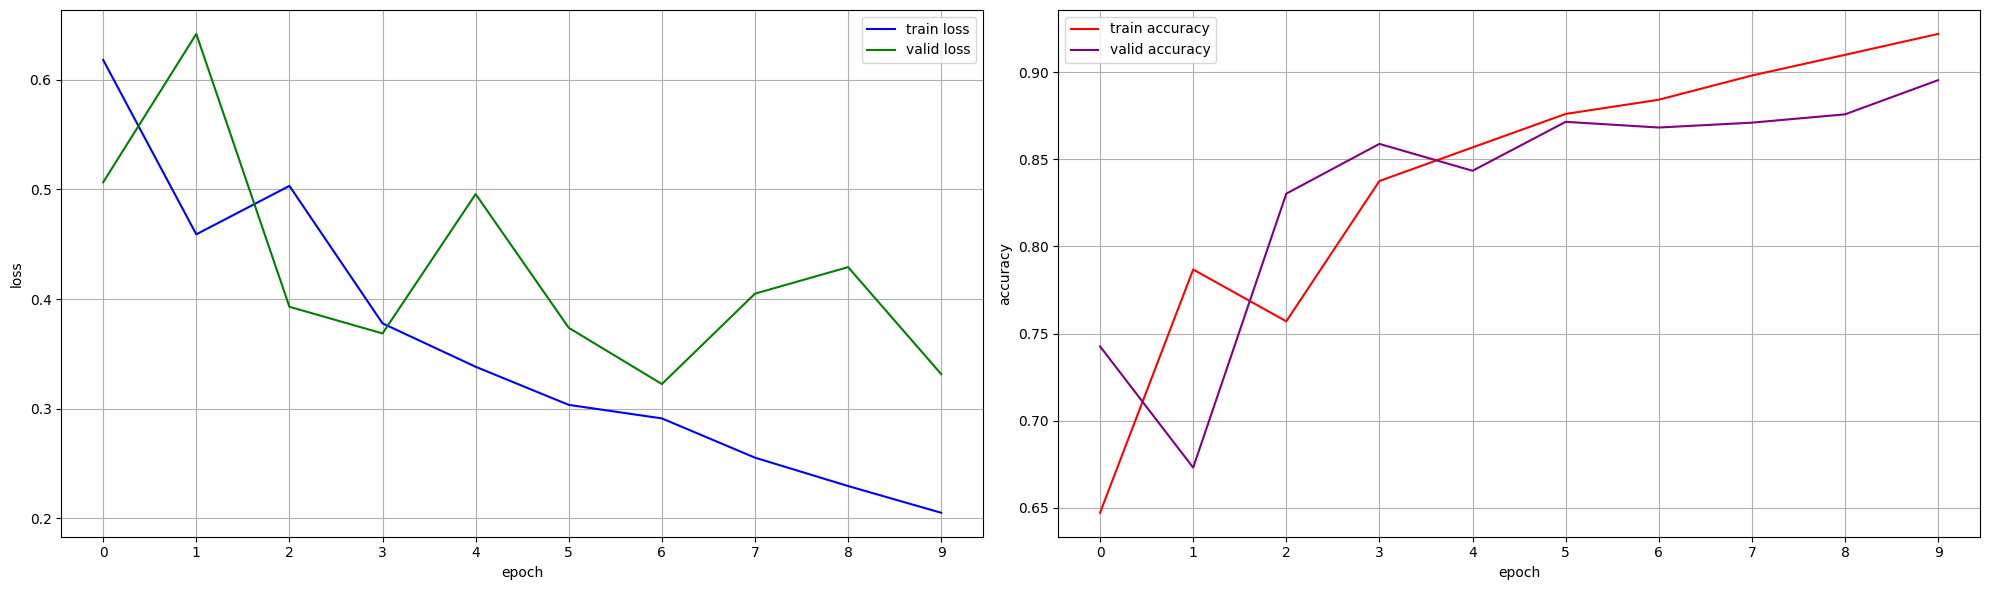

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(metrics["train_losses"], label="train loss", color="blue")
axs[0].plot(metrics["valid_losses"], label="valid loss", color="green")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].set_xticks(range(n_epochs))
axs[0].legend()
axs[0].grid()

axs[1].plot(metrics["train_accs"], label="train accuracy", color="red")
axs[1].plot(metrics["valid_accs"], label="valid accuracy", color="purple")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].set_xticks(range(n_epochs))
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In [21]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...: 100%|██████████| 49/49 [00:03<00:00, 14.13it/s]

test_loss: 0.327, test_acc: 0.862


The predict_sentiment function evaluates the sentiment of a given text using a pre-trained model, tokenizer, and vocabulary, running on a specified device (CPU or GPU). It starts by tokenizing the input text, converting the tokens into numerical indices based on the vocabulary, and adjusting the tensor dimensions for model compatibility. The model then processes this input, and the output logits are transformed into probabilities using the softmax function. The function identifies the class with the highest probability as the predicted sentiment and calculates the confidence level of this prediction. Finally, it interprets the numeric class as either "Negative" or "Positive" sentiment, returning both the sentiment label and its associated probability percentage. This function encapsulates the end-to-end process of sentiment prediction, from raw text to a human-readable sentiment classification with confidence scoring.

In [25]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = round(probability[predicted_class].item()*100,2)

    if predicted_class == 0:
      predicted_class = "Negative"
    if predicted_class == 1:
      predicted_class = "Positive"

    return predicted_class, predicted_probability

In [26]:
text = "The movie 'Sleepy Time' is worst. It is very slow and confusing. The actors do not act well. It's not fun to watch."

predict_sentiment(text, model, tokenizer, vocab, device)

('Negative', 88.95)

In [27]:
text = "Sunset Chronicles' delivers a breathtakingly beautiful narrative, weaving together intricate characters and a captivating \
storyline. The cinematography is stunning, transforming each scene into a vibrant canvas of emotions. While the pacing occasionally \
falters, the performances, particularly from the lead, are deeply compelling. It's a film that stays with you, sparking reflection and \
conversation long after the credits roll."

predict_sentiment(text, model, tokenizer, vocab, device)

('Positive', 99.7)